In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score
import operator
from timeit import default_timer as timer
from src.main import convert_to_one_hot
from src.main import prepare_attribut_data, prepare_result_data
from src.main import DRAW, HOME_WINS, AWAY_WINS
from sklearn.model_selection import train_test_split


In [2]:

train_path_away = '../data/Train_Data/train_away_team_statistics_df.csv'
train_path_home = '../data/Train_Data/train_home_team_statistics_df.csv'
train_path_result = '../data/Train_Data/Y_train.csv'
df_attribut = prepare_attribut_data(train_path_away, train_path_home)
df_result = prepare_result_data(train_path_result)

In [3]:
df_attribut.head()

,ID,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
0,0,3.0,2.0,5.0,2.0,1.0,2.0,2.0,5.0,3.0,...,5.0,5.0,4.0,0.0,6.0,8.0,4.0,3.0,2.0,3.0
1,1,6.0,8.0,3.0,6.0,5.0,8.0,7.0,10.0,6.0,...,0.0,0.0,3.0,1.0,8.0,4.0,10.0,0.0,5.0,3.0
2,2,4.0,2.0,5.0,2.0,8.0,1.0,1.0,2.0,2.0,...,6.0,10.0,4.0,4.0,0.0,8.0,3.0,0.0,9.0,6.0
3,3,7.0,5.0,5.0,6.0,6.0,9.0,9.0,2.0,2.0,...,0.0,0.0,1.0,2.0,0.0,5.0,6.0,3.0,0.0,2.0
4,4,3.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,4.0,...,1.0,0.0,4.0,4.0,9.0,4.0,1.0,4.0,6.0,5.0


In [4]:
df_result.head()

,result
0,-2
1,-1
2,-2
3,1
4,-1


In [5]:

attribut_train, attribut_test, result_train, result_test = train_test_split(df_attribut, df_result, test_size=0.1,
                                                                            random_state=10)


In [6]:
result_test

,result
11028,1
10284,-2
10177,1
7139,1
937,-2
...,...
10569,1
10359,1
745,-2
10906,-1


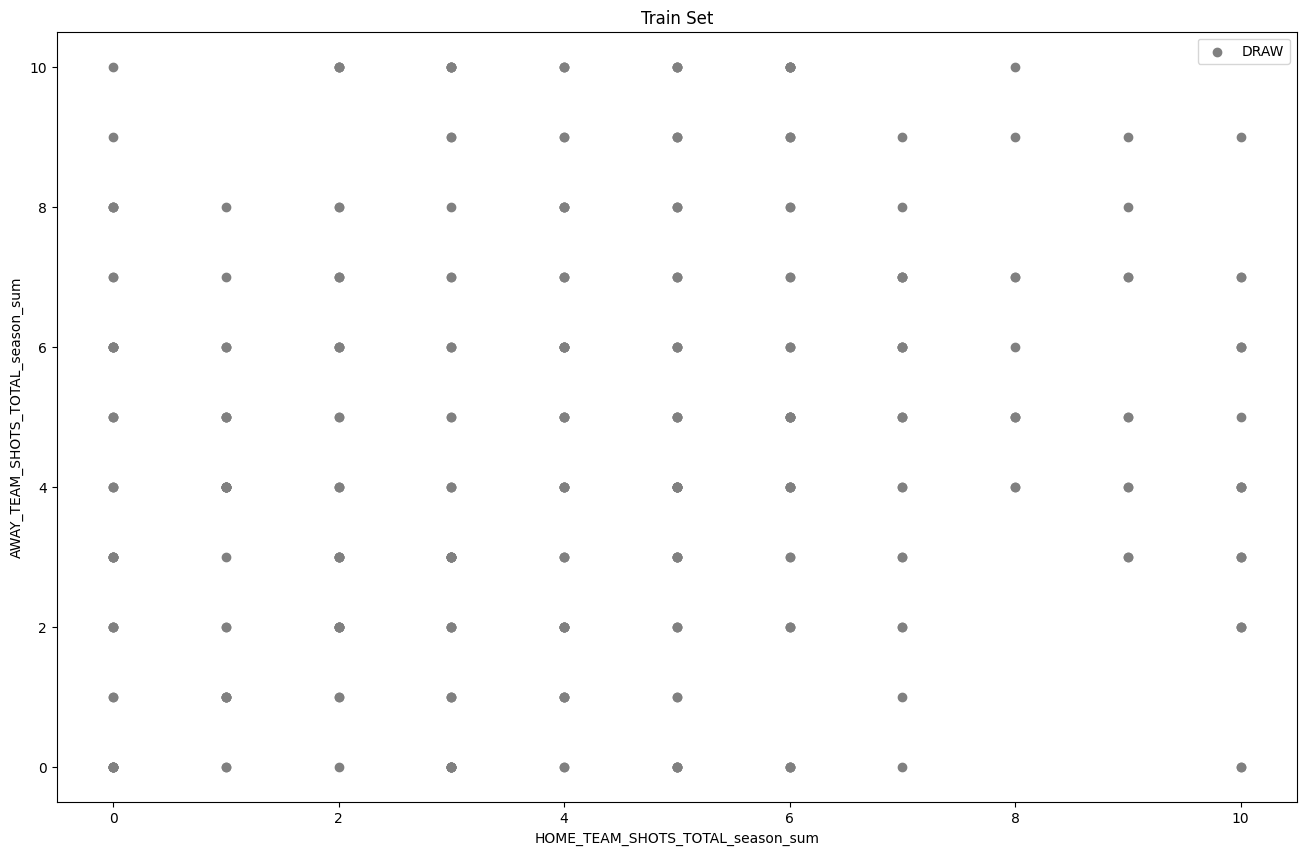

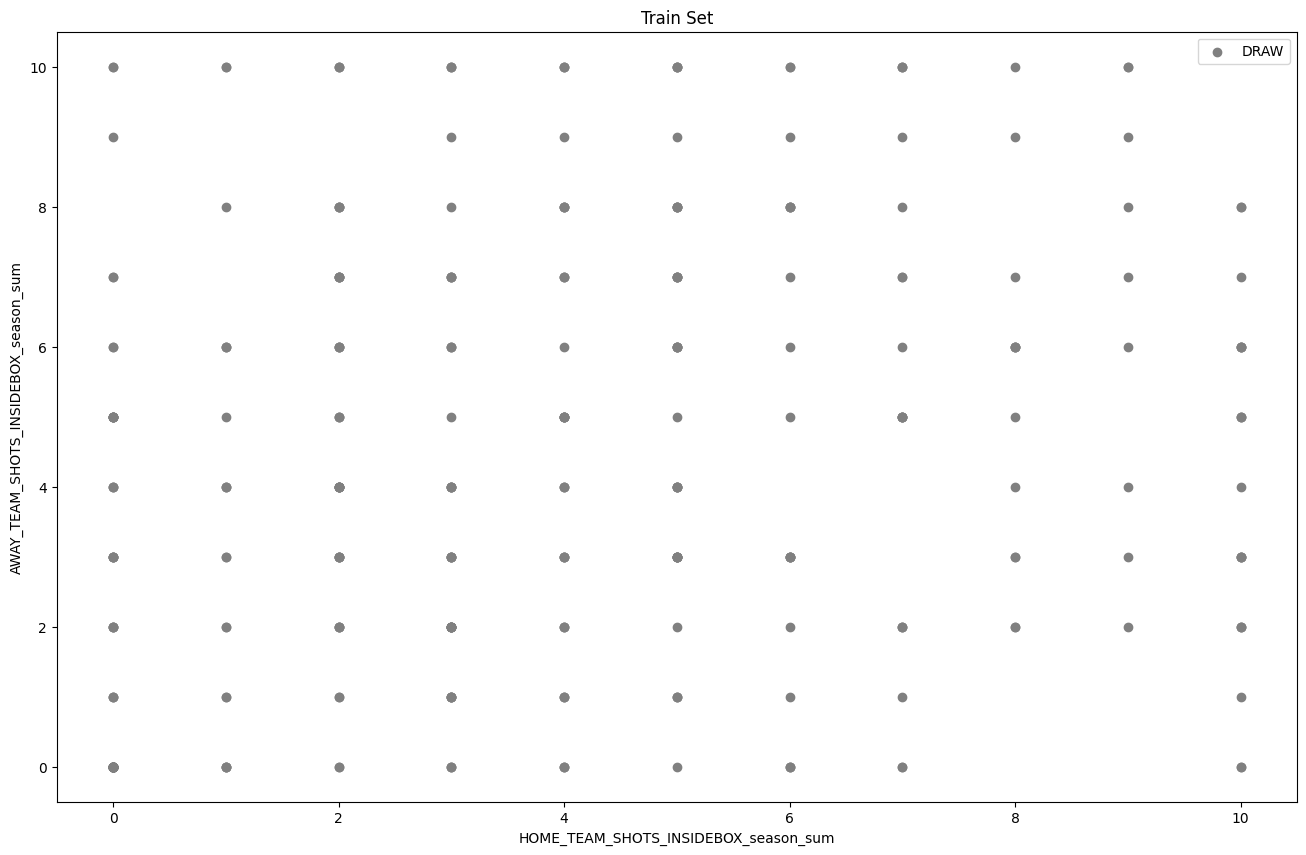

In [29]:

min_index=0
max_index=20000
for i in [1,2]:   

    column_1=attribut_test.columns[i]
    column_2=attribut_test.columns[i+140]
    plt.figure(figsize=(16, 10))
    plt.scatter(attribut_test.loc[(result_test == DRAW).values, column_1].iloc[min_index:max_index], attribut_test.loc[(result_test == DRAW).values, column_2].iloc[min_index:max_index], label="DRAW", color='gray')

    plt.xlabel(column_1)
    plt.ylabel(column_2)
    plt.title("Train Set")
    plt.legend()
    plt.show()

In [10]:
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import LogisticRegression

max_iter_list = [1500]
solver_list = ['lbfgs']  # sag and saga take a lot of time
regularization_factor_list = [ 0.1, 0.0005]
accuracy_dict = {}
time_dict = {}
LR_dict = {}
for max_iter in max_iter_list:
    for solver in solver_list:
        for regularization_factor in regularization_factor_list:
            start = timer()

            LR = LogisticRegression(max_iter=max_iter, solver=solver, C=regularization_factor)
            LR.fit(attribut_train,result_train)
            yhat = LR.predict(attribut_test)
            accuracy = np.round(accuracy_score(result_test, yhat), 4)
            key = f'solver_{solver}_iter_{max_iter}_C_{regularization_factor}'
            accuracy_dict[key] = accuracy
            LR_dict[key] = LR

            end = timer()
            print(f'for this hyperparam {key} the training took ')

            delta = end - start
            minutes = round(delta // 60)
            delta %= 60
            seconds = round(delta)
            time_str = f"{minutes:02d}m{seconds:02d}s"
            time_dict[key] = time_str
            print(time_str)



C:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d 

for this hyperparam solver_lbfgs_iter_1500_C_0.1 the training took 
00m13s
for this hyperparam solver_lbfgs_iter_1500_C_0.0005 the training took 
00m12s


C:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
accuracy_dict

{'solver_lbfgs_iter_1500_C_0.1': 0.4712,
 'solver_lbfgs_iter_1500_C_0.0005': 0.4752}

In [12]:
max_accuracy = max(accuracy_dict.items(), key=operator.itemgetter(1))
LR_best = LR_dict[max_accuracy[0]]

In [13]:
time_dict

{'solver_lbfgs_iter_1500_C_0.1': '00m13s',
 'solver_lbfgs_iter_1500_C_0.0005': '00m12s'}

In [14]:
max_accuracy

('solver_lbfgs_iter_1500_C_0.0005', 0.4752)

In [15]:
yhat = LR_best.predict(attribut_test)
np.round(accuracy_score(result_test, yhat), 4)

0.4752

In [16]:
yhat

array([ 1,  1, -2, ..., -2, -2,  1])

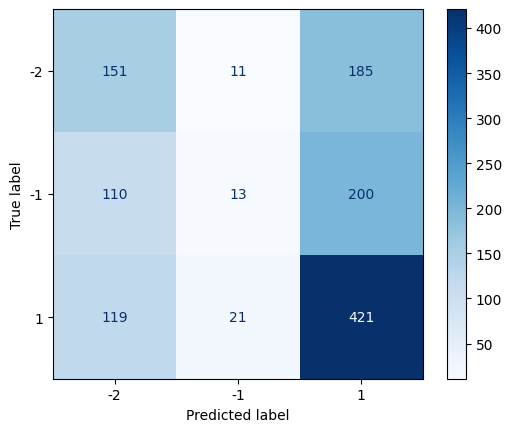

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(result_test, yhat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[-2, -1, 1], )
disp.plot(cmap="Blues")

In [18]:
test_path_away = '../data/Test_Data/test_away_team_statistics_df.csv'
test_path_home = '../data/Test_Data/test_home_team_statistics_df.csv'
df_attribut_test = prepare_attribut_data(test_path_away, test_path_home,is_test=True)

In [19]:
df_attribut_test

,ID,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
0,12303,3.0,6.0,5.0,1.0,3.0,9.0,8.0,10.0,6.0,...,6.0,0.0,1.0,4.0,0.0,8.0,7.0,2.0,7.0,0.0
1,12304,3.0,2.0,4.0,2.0,6.0,1.0,1.0,2.0,4.0,...,0.0,0.0,3.0,6.0,8.0,5.0,1.0,1.0,7.0,9.0
2,12305,7.0,10.0,8.0,8.0,1.0,4.0,5.0,0.0,10.0,...,10.0,0.0,0.0,2.0,0.0,4.0,2.0,3.0,0.0,9.0
3,12306,5.0,7.0,5.0,9.0,5.0,7.0,6.0,3.0,5.0,...,1.0,5.0,4.0,5.0,10.0,9.0,6.0,9.0,7.0,3.0
4,12307,5.0,4.0,6.0,3.0,5.0,0.0,0.0,2.0,2.0,...,3.0,0.0,6.0,5.0,0.0,4.0,3.0,10.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25363,37666,5.0,5.0,5.0,5.0,7.0,6.0,6.0,4.0,6.0,...,5.0,0.0,5.0,4.0,5.0,0.0,3.0,10.0,5.0,10.0
25364,37667,5.0,5.0,2.0,8.0,3.0,7.0,7.0,2.0,2.0,...,5.0,5.0,6.0,6.0,8.0,0.0,3.0,5.0,1.0,0.0
25365,37668,10.0,10.0,10.0,8.0,8.0,5.0,5.0,2.0,6.0,...,4.0,0.0,0.0,5.0,0.0,3.0,0.0,3.0,0.0,1.0
25366,37669,4.0,3.0,5.0,3.0,7.0,7.0,7.0,0.0,4.0,...,6.0,0.0,10.0,4.0,8.0,6.0,4.0,2.0,0.0,3.0


In [20]:
yhat_test = LR_best.predict(df_attribut_test)

In [21]:
y_pred_test = convert_to_one_hot(yhat_test)

In [22]:
test_prediction = pd.concat([df_attribut_test['ID'], y_pred_test], axis=1)

In [23]:
test_prediction.to_csv('../submission/logistic_benchmark_submission.csv', index=False)